In [1]:
from icevision.all import *
from icevision.models.checkpoint import *

/root/miniforge-pypy3/envs/icevision/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /root/.icevision/mmdetection_configs/mmdetection_configs-2.20.1/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17


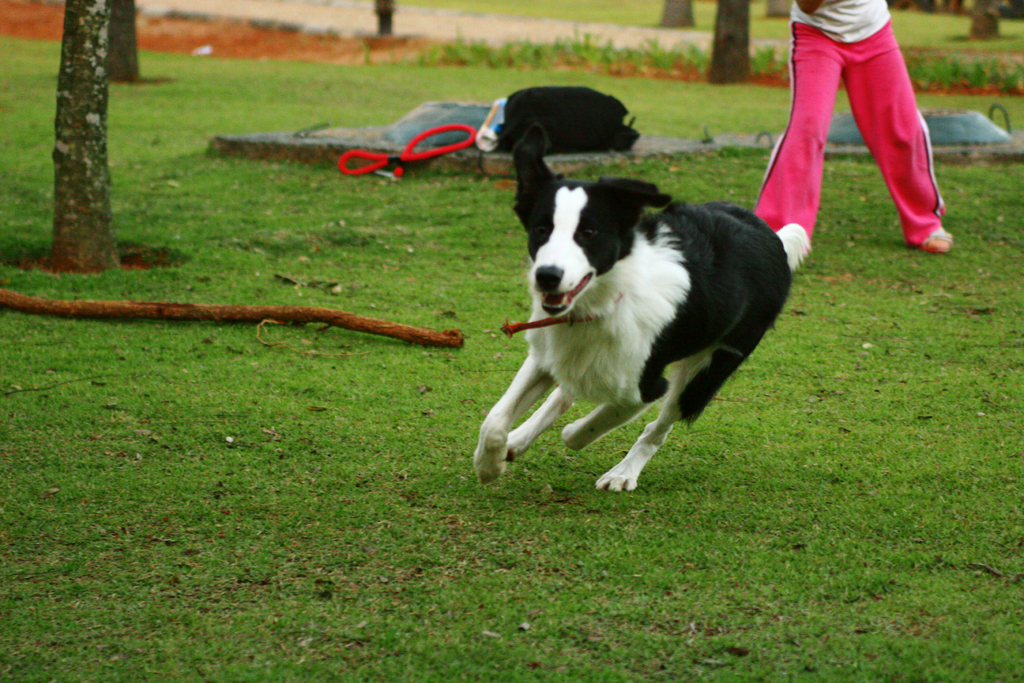

In [2]:
# Pick your images folder
path_to_image_folder = '/workspace/yolo_v8_training/oiv7_full/validation/'
img_files = get_image_files(path_to_image_folder)

img = PIL.Image.open(img_files[4])
img

In [3]:
checkpoint_path = "./models/model_checkpoint.pth"

checkpoint_and_model = model_from_checkpoint(checkpoint_path)
model = checkpoint_and_model["model"]
model_type = checkpoint_and_model["model_type"]
class_map = checkpoint_and_model["class_map"]
img_size = checkpoint_and_model["img_size"]
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(img_size), tfms.A.Normalize()])

load checkpoint from local path: ./models/model_checkpoint.pth


2024-04-04 09:30:34,187 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet50'}
2024-04-04 09:30:34,188 - mmcv - INFO - load model from: torchvision://resnet50
2024-04-04 09:30:34,189 - mmcv - INFO - load checkpoint from torchvision path: torchvision://resnet50
2024-04-04 09:30:34,274 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2024-04-04 09:30:34,292 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2024-04-04 09:30:34,320 - mmcv - INFO - initialize VFNetHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01, 'override': {'type': 'Normal', 'name': 'vfnet_cls', 'std': 0.01, 'bias_prob': 0.01}}
2024-04-04 09:30:34,356 - mmcv - INFO - 
backbone.conv1.weight - torch.Size([64, 3, 7, 7]): 
PretrainedInit: load from torchvision://resnet50 
 
2024-04-04 09:30:34,357 - mmcv - INFO -

In [4]:
# Load best model checkpoint

from mmcv.runner import _load_checkpoint

checkpoint_and_model['checkpoint']['state_dict'] = _load_checkpoint("models/best_model.pth")

load checkpoint from local path: models/best_model.pth


In [5]:
pred_dict = model_type.end2end_detect(img, valid_tfms, model, 
                                      class_map=class_map, 
                                      detection_threshold=0.5,
                                      display_label=True, 
                                      display_bbox=True, 
                                      return_img=True, 
                                      font_size=50, 
                                      label_color="#FF59D6")

/root/miniforge-pypy3/envs/icevision/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


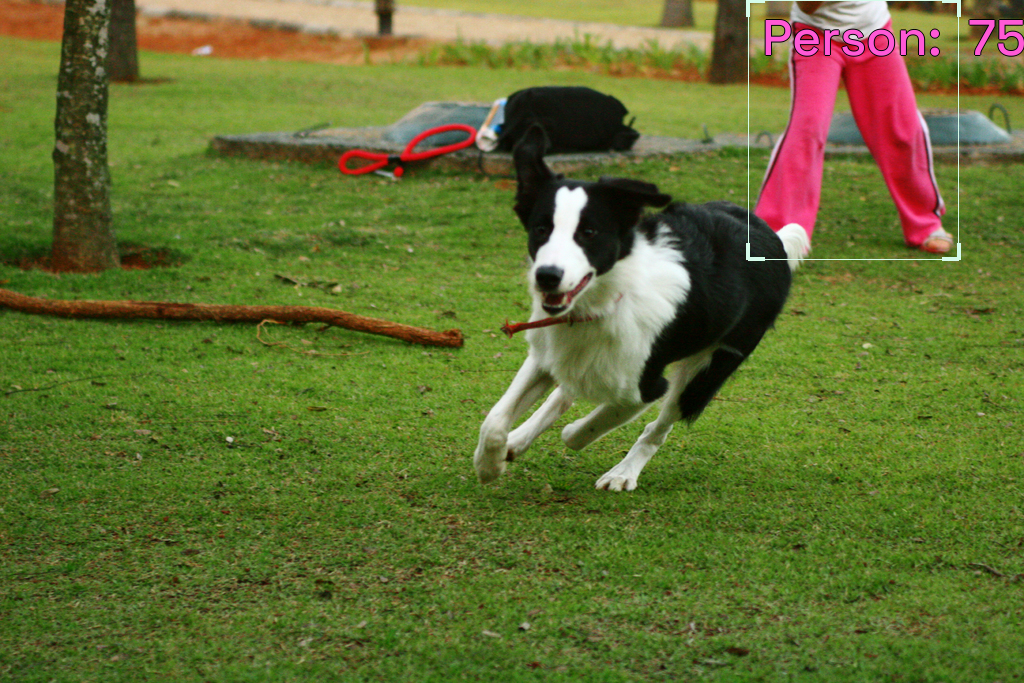

In [6]:
pred_dict["img"]

In [13]:
# Create a dataset with appropriate images 
imgs_array = [PIL.Image.open(Path(fname)) for fname in img_files[15:30]]
infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map=class_map)

# Batch Inference
infer_dl = model_type.infer_dl(infer_ds, batch_size=16, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

  0%|          | 0/1 [00:00<?, ?it/s]

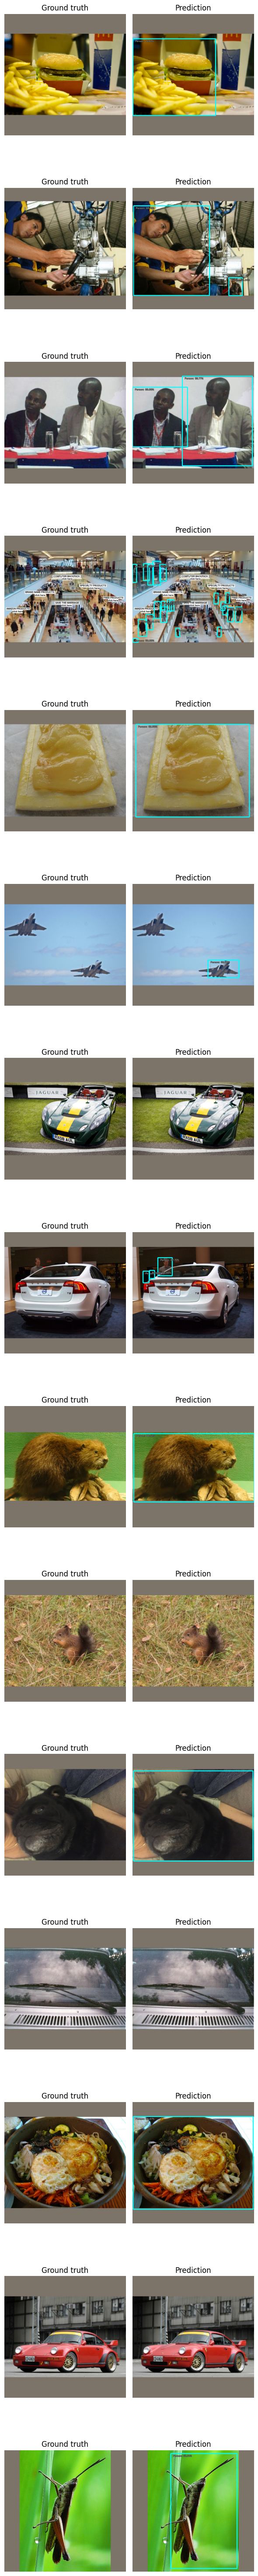

In [14]:
%matplotlib inline
show_preds(preds=preds, display_label=True, color_map={"person":"cyan"}, bbox_thickness=5)